In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
from numpy import heaviside
from math import *
import pandas as pd
from numba import jit

@jit
# Potential function
def U(phi,I=1.01,gamma=1,T=4.615120516841259, tau=1):
    value = (I/gamma)*(1-np.exp(-gamma*T*phi/tau))
    return value
@jit
# Function to convert potential to 'phase' corresponding to Mirollo-Strogatz model
def U_inv(y,I=1.01,gamma=1,T=4.615120516841259,tau=1):
    value = (tau/(gamma*T))*np.log((1-(gamma*y/I))**(-1))
    return value

In [2]:
## Loading Inhibitory and Excitatory Edge topology from a 81 × 81 Matrix specifying 20 connections for each neuron 
# Import Sudoku matrices: (rows: pre-synaptic, columns: post-synaptic)

inhib_connect = np.loadtxt('Clueless_Sudoku_inhib.txt', dtype=int)
excit_connect = np.loadtxt('Clueless_Sudoku_excit.txt', dtype=int)

# Get tuples of corresponding connection indices for putting in Brian2's synapse connect() function
inhib_pre, inhib_post = inhib_connect.nonzero()
excit_pre, excit_post = excit_connect.nonzero()

In [ ]:
start_scope()
N = 81                          # No. of neurons
tau = 10*ms                     # Time constant of neuron
A_osc = 0.2                     # Oscillation amplitude #?
freq = 25*Hz                    # Frequency of common oscillatory drive #?
transm_delay = pow(10,-5)*ms    # Delay between firing and reception of pulse by post-synaptic neuron
Ib_low = 0.58                   # Lower limit of bias current
Ib_upp = 0.64                   # Upper limit of bias current
Ib_val = [Ib_low + (Ib_upp-Ib_low)*( i/9.0 ) for i in range(9)]
order_Ib = np.array([9,1,7,5,2,3,4,6,8]) 
#Ib_array = np.zeros(N,dtype=float)


# Pulse strengths: inhibitory and excitatory
C_inh = -2.7*pow(10,-2)
C_exc = +2.8*pow(10,-4)

eqs = '''
dv/dt = (I+Ib-v)/tau : 1
phase = (freq*t) % 1.0 : 1
I = 0.4 + A_osc*sin(2*pi*phase) : 1
Ib : 1
'''
# Create a neuron group 'G' following the above equation
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
G.v = 'rand()' #?
G.Ib = 0.58

# Inhibitory synapses
S_inhib = Synapses(G,G, on_pre='v_post += C_inh', delay=transm_delay)
S_inhib.connect(i=inhib_pre, j=inhib_post)

# Excitatory synapses
S_excit = Synapses(G,G, on_pre='v_post += C_exc', delay=transm_delay)
S_excit.connect(i=excit_pre, j=excit_post)

# Record of potential for all neurons
potential = StateMonitor(G, 'v', record=True)
# Record of oscillatory drive (common to all neurons)
osc = StateMonitor(G, "I", record=0)
# Record of all spikes
firing_time = SpikeMonitor(G, variables='phase')
run(4000*ms)

# Raster plot of firing
# Plot firing from 'index1' no. of iterations before end

figure(figsize=(20,8))
title('Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh), fontsize=16)
plot(firing_time.t/ms, firing_time.i, '.k')
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
show()

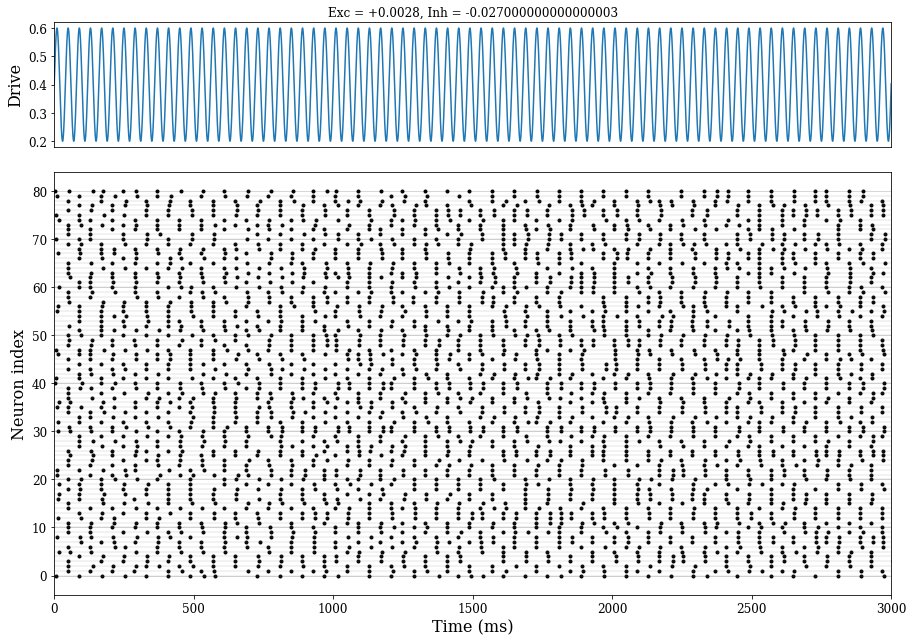

In [67]:
fig = figure(figsize=(15,10))
gs = fig.add_gridspec(4,1)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12) 
fig.tight_layout()
fig.subplots_adjust(top=0.92)
rcParams['font.family']='serif'

x_lim = (0,3000)
# Plot of oscillatory drive
drplt = fig.add_subplot(gs[0,:])
drplt.set_title('Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh))# + ', '+ 'A_noise = ' + str(A_noise), fontsize=16)
drplt.plot(osc.t/ms, osc.I[0])
drplt.set_xlim(x_lim)
drplt.set_xticks([])
drplt.set_ylabel('Drive', fontsize=16)

# Plot of firing of neurons 
fireplot = fig.add_subplot(gs[1:,:])
fireplot.plot(firing_time.t/ms, firing_time.i,'.k')
fireplot.set_xlim(x_lim)
fireplot.grid(True, 'both','y',linewidth=0.5)
for i in range(80):
    fireplot.axhline(y=i, linewidth=0.2, color='gray')

fireplot.set_ylabel('Neuron index', fontsize=16)
fireplot.set_xlabel('Time (ms)', fontsize=16)
#savefig('Sudoku_complete_bias/puzzle_'+str(puzzle_no)+'_firing_'+str(trial_no)+'.png')
#savefig('k-partite_plots_osc/' + str(partite)+'-partite/' + str(partite) + '-partite_firing_' + str(trial_no) + '.png')
show()

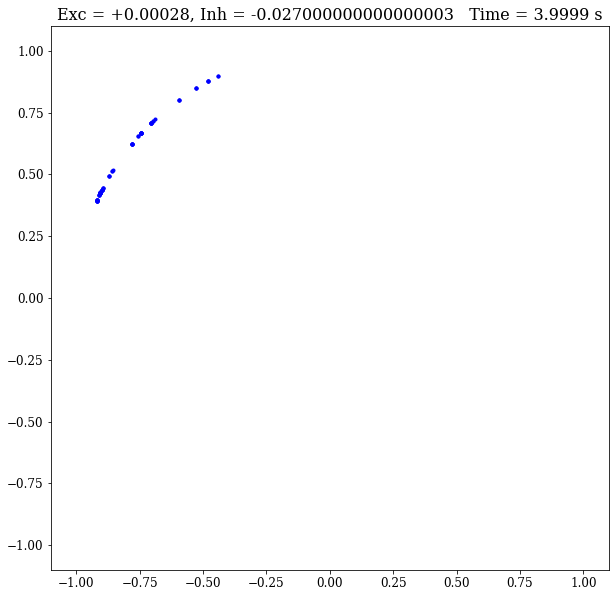

In [86]:
# Plot phases on a unit circle
# 'index3' defines which iteration (from the end if index3 is -ve) is being looked at
pot_arr = potential.v.copy()
pot_arr[pot_arr>1] = 1
phase = U_inv(pot_arr)
index3 = -1

sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])

figure(figsize=(10,10))
plot(cos_phase,sin_phase,'b.')

xlim((-1.1,1.1))
ylim((-1.1,1.1))
plt.title('Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh) + '   Time = ' + str(potential.t[index3]), fontsize=16)
show()

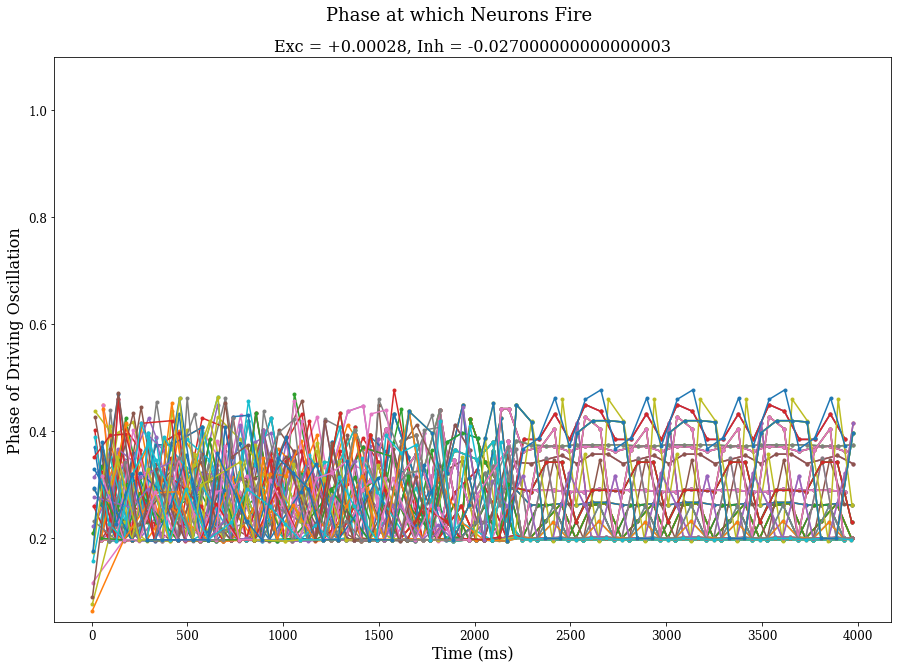

In [87]:
# Plot the phase of oscillation at the time of firing of a neuron
# Plot this for all neurons together in one graph
figure(figsize=(15,10))
tight_layout()
subplots_adjust(top=0.91)
suptitle('Phase at which Neurons Fire', fontsize=18)
title('Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh), fontsize=16)
for i in range(N):
    plot(firing_time.values('t')[i]/ms, firing_time.values('phase')[i], '.-')
    #if i%9 == 0:
        #plot(firing_time.values('t')[i]/ms, firing_time.values('phase')[i], color=colours[i//9], marker='.', label='G '+str(i//9+1))
    #else:
        #plot(firing_time.values('t')[i]/ms, firing_time.values('phase')[i], color=colours[i//9], marker='.')
ylim(top=1.1)
xlabel('Time (ms)', fontsize=16)
ylabel('Phase of Driving Oscillation', fontsize=16)
#figtext(0.70,0.87,'Increasing $I_b$: '+str(order_Ib),fontsize=12,
#       bbox={'facecolor':'w','alpha':0.2,'pad':6})
#legend(loc='upper right',ncol=partite, fontsize='large')
#savefig('Sudoku_complete_bias/puzzle_'+str(puzzle_no)+'_phase-lock_'+str(trial_no)+'.png')
show()
print()

In [ ]:
#The driving current or Input Stimulus is specified directly as 1 input of 100 Hz whcih is given every dt timestep
P = PoissonInput(G, 'v', 1,10*Hz, weight=5)

# Record of potential for all neurons
potential = StateMonitor(G, 'v', record=True)

run(5000*ms)

# Record of potential for all neurons
Pot = StateMonitor(G, 'v', record=True)
# Record of oscillatory drive (common to all neurons)
Osc = StateMonitor(G, "I", record=0)
# Record of all spikes
Firing_time = SpikeMonitor(G, variables='phase')

In [ ]:
index_1 = -300
figure(figsize=(20,6))
title('Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh), fontsize=16)
plot(Firing_time.t[index1:]/ms, Firing_time.i[index1:], '.k')
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
show()

# Plot phases on a unit circle
# 'index3' defines which iteration (from the end if index3 is -ve) is being looked at
pot_arr = potential.v.copy()
pot_arr[pot_arr>1] = 1
phase = U_inv(pot_arr)
index_3 = -1

sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])

figure(figsize=(10,10))
plot(cos_phase,sin_phase,'b.')

xlim((-1.1,1.1))
ylim((-1.1,1.1))
plt.title('Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh) + '   Time = ' + str(Pot.t[index3]), fontsize=16)
show()